In [6]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta
import matplotlib.pyplot as plt

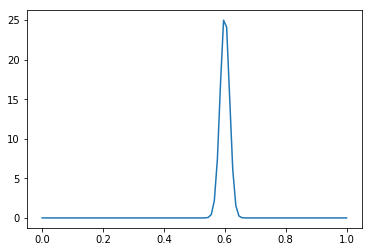

In [3]:
xs = np.linspace(0,1,100)
ys = beta.pdf(xs,609,406)
plt.plot(xs, ys)

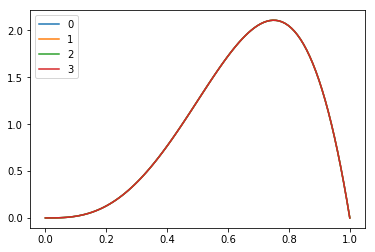

In [24]:
for i in range(4):
    xs = np.linspace(0,1,100)
    ys = beta.pdf(xs,4,2)
    plt.plot(xs, ys)
    plt.legend(range(4))
    

Set up some parameters for the rest of the cells.

In [5]:
# probability of each drug's effectiveness
drug_effectiveness = np.array([0.1,0.4,0.65,0.35])
K = len(drug_effectiveness)
N_trials = 8

if N_trials/K != int(N_trials/K):
    print('The even split trials will not work correctly!')

patients_per_trial = 10
drug_effectiveness

array([0.1 , 0.4 , 0.65, 0.35])

In [6]:
def sample_drug(i):
    # administer a drug to a patient, get a random outcome
    if np.random.rand() > drug_effectiveness[i]:
        return 0
    else:
        return 1

Trial types:

* Even Split Trials - Divide the available trials evenly among the various drugs.
* Random Trial - Pick a random drug to try for each trial.
* Bayesian - Use Bayesian optimization with Thompson sampling

In [7]:
def even_split_test():
    results = np.zeros(shape = (K,2))
    trials_per_drug = int(N_trials/K)
    for i in range(K):
        for j in range(trials_per_drug):
            for _ in range(patients_per_trial):
                results[i][sample_drug(i)] += 1
    return results
even_split_test()

array([[19.,  1.],
       [12.,  8.],
       [ 8., 12.],
       [14.,  6.]])

In [8]:
def random_test():
    choices = np.random.choice(range(K), N_trials)
    results = np.zeros(shape = (K,2))
    for choice in choices:
        for _ in range(patients_per_trial):
            results[choice][sample_drug(choice)] += 1
    return results

random_test()            

array([[25.,  5.],
       [18., 22.],
       [ 0.,  0.],
       [ 9.,  1.]])

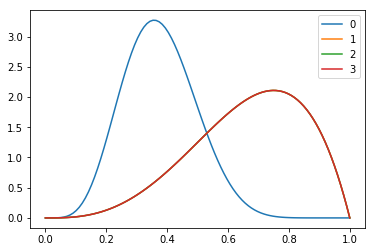

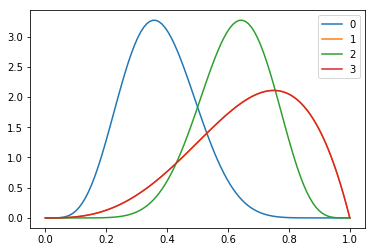

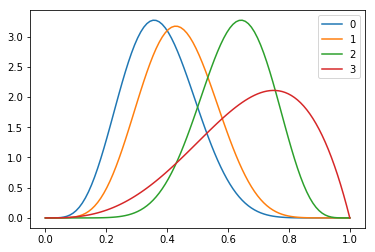

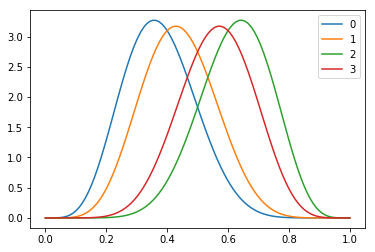

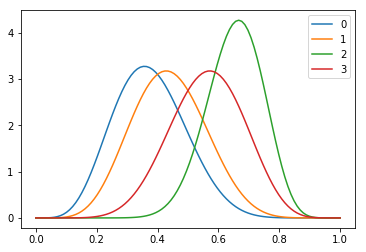

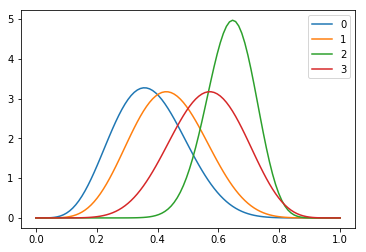

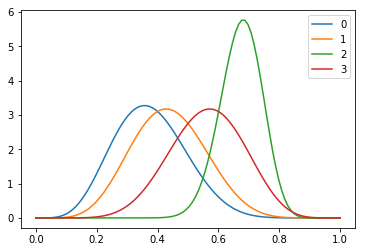

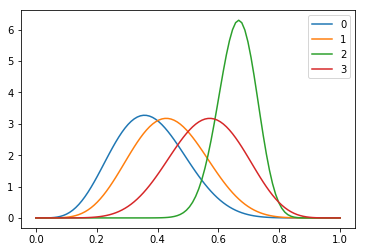

array([[ 8.,  4.],
       [ 7.,  5.],
       [17., 35.],
       [ 5.,  7.]])

In [26]:

def bayesian_test(make_graphs = False):
    parameters = np.zeros(shape=(K,2))
    parameters[:,1] = 4
    parameters[:,0] = 2
    
    for _ in range(N_trials):
        estimated_ps = np.zeros(K)
        for i in range(K):
            estimated_ps[i] = np.random.beta(parameters[i][1], parameters[i][0])
        # print(estimated_ps)
        drug_to_try = estimated_ps.argmax()
        # print('Trying drug',drug_to_try)
        old_parameters = parameters.copy()
        for _ in range(patients_per_trial):
            parameters[drug_to_try][sample_drug(drug_to_try)] += 1
        # print(parameters-old_parameters)
        if make_graphs:
            for i in range(K):
                xs = np.linspace(0,1,100)
                ys = beta.pdf(xs,parameters[i][1], parameters[i][0])
                plt.plot(xs, ys)
                plt.legend(range(K))
            plt.show()

    maxes = parameters[:,1]/(parameters[:,0]+parameters[:,1])
    
    return parameters-2

bayesian_test(make_graphs = True)

Now, let's run a trial 1000 times to get a good idea of how each method perfoms. We can also keep track of how many patients were cured in the process.

In [16]:
N_runs = 2

def super_trial(method, N_runs):
    patients_cured = 0
    best_drugs = np.zeros(K)
    for _ in range(N_runs):
        results = method()
        patients_cured += results[:,1].sum()
        
        effectiveness_estimates = results[:,1]/(results[:,0] + results[:,1]+0.0001)
        winners = effectiveness_estimates == effectiveness_estimates.max()
        best_drug = np.random.choice(np.flatnonzero(winners))
        best_drugs[best_drug] += 1
    return patients_cured, best_drugs

super_trial(even_split_test, 2)

(56.0, array([0., 0., 2., 0.]))

In [17]:
super_trial(even_split_test, 1000)

(30046.0, array([  0.,  47., 933.,  20.]))

In [18]:
super_trial(random_test, 1000)

(30106.0, array([  0.,  96., 838.,  66.]))

In [27]:
super_trial(bayesian_test, 1000)

(45428.0, array([ 11.,  47., 906.,  36.]))

Making some graphs! Nothing really important here, just building some visualizations to show off the data.

   drug number trial method  value
0            0         each      0
1            1         each     47
2            2         each    933
3            3         each     20
4            0  pessimistic      0
5            1  pessimistic     93
6            2  pessimistic    878
7            3  pessimistic     29
8            0      neutral     11
9            1      neutral     60
10           2      neutral    916
11           3      neutral     24
12           0   optimistic     11
13           1   optimistic     47
14           2   optimistic    906
15           3   optimistic     36


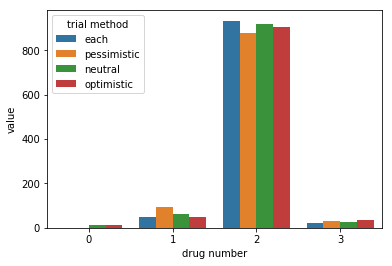

In [31]:
df = pd.DataFrame({
    'each':{'0':0, '1':47, '2':933, '3':20},
    'pessimistic':{'0':0, '1':93, '2':878, '3':29},
    'neutral':{'0':11,'1':60, '2':916, '3':24},
    'optimistic':{'0':11,'1':47,'2':906, '3':36}})

df = df.reset_index().rename(columns = {'index':'drug number'})
df = df.melt(id_vars = ['drug number'], value_vars = ['each','pessimistic','neutral','optimistic'])
df = df.rename(columns = {'variable': 'trial method'})
print(df)
sns.barplot(data = df, x='drug number', hue = 'trial method', y = 'value')

In [661]:
# try each
# drug 0 is best in 0 times
# drug 1 is best 47 times
# drug 2 is best in 933 times
# drug 3 is best in 20 times
# 3004.6 patients are cured, on average

# pessimistic
# drug 0 is best 0 times
# drug 1 is best 93 times
# drug 2 is best 878 times
# drug 3 is best 29 times
# 3952.4 patients are cured, on average

# half and half
# drug 0 best 0 times
# drug 1 best 60 times
# drug 2 best 916 times
# drug 3 best 24 times
# 3814.6 patients saved, on average

# optimistic
# picked drug 0: 11 times
# picked drug 1: 47 times
# picked drug 2: 906 times
# picked drug 3: 36 times
# saved an average of 4542.8 patients per trial


  trial method       0
0         each  3004.6
1  pessimistic  3982.4
2      neutral  3814.6
3   optimistic  4542.9


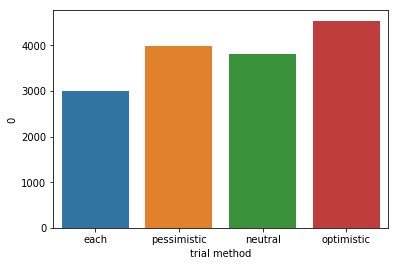

In [42]:
df = pd.Series({
    'each': 3004.6,
    'pessimistic':3982.4,
    'neutral':3814.6,
    'optimistic':4542.9
})

df = df.reset_index().rename(columns = {'index':'trial method'})

print(df)

sns.barplot(data = df, x='trial method', y = 0)

